In [5]:

import yaml
# from train_eval.trainer import Trainer
# import os
# os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
# os.environ['CUDA_VISIBLE_DEVICES'] = "0"


In [6]:
with open("/home/stanliu/code/pgp/PGP/configs/raster.yml", 'r') as yaml_file:
    cfg = yaml.safe_load(yaml_file)

In [7]:
ds_type = cfg['dataset'] + '_' + cfg['agent_setting'] + '_' + cfg['input_representation']
cfg['train_set_args']
# cfg['encoder_args']

{'split': 'train',
 't_h': 2,
 't_f': 6,
 'map_extent': [-61, 61, -22, 100],
 'img_size': [488, 488],
 'polyline_resolution': 1,
 'polyline_length': 20,
 'traversal_horizon': 15,
 'random_flips': True}

In [4]:
trainer = Trainer(cfg, "/home/stanliu/data/mnt/nuScenes/", "/home/stanliu/code/pgp/PGP/preprocess_raster")

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 85.784 seconds.
Reverse indexing ...
Done reverse indexing in 11.4 seconds.


In [5]:
for i,data in enumerate(trainer.tr_dl):
    data_test=data['inputs']
    break


In [6]:
print(data_test.keys())

dict_keys(['instance_token', 'sample_token', 'map_representation', 'surrounding_agent_representation', 'target_agent_representation'])


In [8]:
from nuscenes.prediction import PredictHelper
from nuscenes.prediction.input_representation.static_layers import StaticLayerRasterizer
from nuscenes.nuscenes import NuScenes
map_extent=[ -50, 50, -20, 80 ]
img_size=[400,400]
resolution = (map_extent[1] - map_extent[0]) /  img_size[1]
nusc = NuScenes(version='v1.0-trainval', dataroot="/home/stanliu/data/mnt/nuScenes/", verbose=True)
helper=PredictHelper(nusc)
map_rasterizer = StaticLayerRasterizer(helper,
                                        resolution=resolution,
                                        meters_ahead=map_extent[3],
                                        meters_behind=-map_extent[2],
                                        meters_left=-map_extent[0],
                                        meters_right=map_extent[1])

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 57.369 seconds.
Reverse indexing ...
Done reverse indexing in 12.1 seconds.


In [9]:
from nuscenes.prediction.input_representation.static_layers import *
import matplotlib.pyplot as plt
import numpy as np
idx=1
instance_token=data_test['instance_token'][idx]
sample_token = data_test['sample_token'][idx]



sample_annotation = map_rasterizer.helper.get_sample_annotation(instance_token, sample_token)
map_name = map_rasterizer.helper.get_map_name_from_sample_token(sample_token)

x, y = sample_annotation['translation'][:2]

yaw = quaternion_yaw(Quaternion(sample_annotation['rotation']))

yaw_corrected = correct_yaw(yaw)

image_side_length = 2 * max(map_rasterizer.meters_ahead, map_rasterizer.meters_behind,
                            map_rasterizer.meters_left, map_rasterizer.meters_right)
image_side_length_pixels = int(image_side_length / map_rasterizer.resolution)
   
patchbox = get_patchbox(x, y, image_side_length)

angle_in_degrees = angle_of_rotation(yaw_corrected) * 180 / np.pi

canvas_size = (image_side_length_pixels, image_side_length_pixels)

masks = map_rasterizer.maps[map_name].get_map_mask(patchbox, angle_in_degrees, map_rasterizer.layer_names, canvas_size=canvas_size)
## Get drivable area mask
mask_drivable_area=masks[0]

images = []
for mask, color in zip(masks, map_rasterizer.colors):
    images.append(change_color_of_binary_mask(np.repeat(mask[::-1, :, np.newaxis], 3, 2), color))

lanes = draw_lanes_in_agent_frame(image_side_length_pixels, x, y, yaw, radius=50,
                                    image_resolution=map_rasterizer.resolution, discretization_resolution_meters=1,
                                    map_api=map_rasterizer.maps[map_name])

images.append(lanes)

image = map_rasterizer.combinator.combine(images)

row_crop, col_crop = get_crops(map_rasterizer.meters_ahead, map_rasterizer.meters_behind, map_rasterizer.meters_left,
                                map_rasterizer.meters_right, map_rasterizer.resolution,
                                int(image_side_length / map_rasterizer.resolution))

/home/stanliu/.local/lib/python3.7/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/stanliu/.local/lib/python3.7/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


In [10]:
row_crop, col_crop

(slice(0, 400, None), slice(120, 520, None))

In [ ]:
plt.imshow(images[0][row_crop, col_crop, :])
plt.show()
plt.imshow(lanes[row_crop, col_crop, :])
plt.show()
plt.imshow(image[row_crop, col_crop, :])
plt.show()
plt.imshow(images[0][row_crop, col_crop, 2]/255)


In [ ]:
data_test['map_representation'][0].dtype

In [6]:
import torch
target_agent_representation = data_test['target_agent_representation']
surrounding_agent_representation = data_test['surrounding_agent_representation']
map_representation = data_test['map_representation'][0]
mask= data_test['map_representation'][1].type(torch.bool)

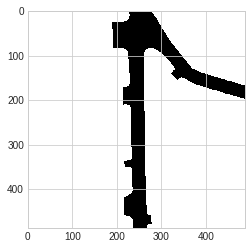

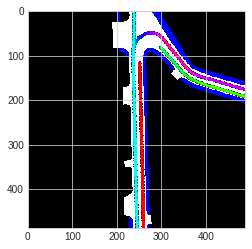

In [34]:
idx=10
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.array(mask[idx]))
plt.show()
plt.imshow(np.array(map_representation[idx]).transpose(1,2,0))

In [2]:

from torchvision.models import resnet34
# input = torch.cat((map_representation, surrounding_agent_representation), dim=1)
# resnet_model = resnet34(pretrained=False)
# conv1_new = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# modules = list(resnet_model.children())[:-2]

# modules[0] = conv1_new
# backbone = nn.Sequential(*modules)
# data_test['target_agent_representation'].float().dtype

In [4]:
from models.encoders.raster_encoder import *
encoder=RasterEncoder(cfg['encoder_args'])
# encodings=encoder.forward(data_test)

NameError: name 'cfg' is not defined

In [17]:
encodings['context_encoding']["combined"].shape

torch.Size([32, 256, 512])

In [1]:
import torch
import torch.nn.modules as nn
fake_map_encodings=torch.randn(32, 512, 16,16)
fake_agent_input=torch.randn(32, 32).unsqueeze(2).unsqueeze(3).repeat(1,1,16,16)

In [2]:
concatenated_encodings=torch.cat([fake_map_encodings,fake_agent_input],dim=1)
conv1d1=nn.Conv2d(544, 528, kernel_size=1, stride=1, bias=False)
conv1d2=nn.Conv2d(528, 512, kernel_size=1, stride=1, bias=False)
test_dim_reduction=nn.Sequential(conv1d1,nn.BatchNorm2d(528),nn.ReLU(),conv1d2,nn.BatchNorm2d(512),nn.ReLU())
fake_feature=test_dim_reduction(concatenated_encodings)
fake_feature=fake_feature.view(fake_feature.shape[0], fake_feature.shape[1], -1).permute(0, 2, 1)

fake_feature.shape

torch.Size([32, 256, 512])

In [3]:
from models.library.blocks import *
transpose_convs = nn.Sequential(
            TransposeCNNBlock(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=0),
            TransposeCNNBlock(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=0),
            TransposeCNNBlock(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=0),
            TransposeCNNBlock(in_channels=64, out_channels=32, kernel_size=3, stride=2, output_padding=1),
            TransposeCNNBlock(in_channels=32, out_channels=20, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
final_convs = nn.Sequential(CNNBlock(in_channels=20, out_channels=20, kernel_size=7,padding=3),
                            CNNBlock(in_channels=20, out_channels=20, kernel_size=7,padding=3))

# transconv1=TransposeCNNBlock(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=0, output_padding=0)

In [12]:
upsampled_test=final_convs(transpose_convs(fake_feature))
# augmented_mask=mask.unsqueeze(-1)
print(upsampled_test[:,:,::2,::2].shape)


torch.Size([32, 20, 244, 244])


In [22]:
import numpy as np


import torch
from torch import nn

# from model.decode import generic_decode

# from utils.image import gaussian_radius, draw_umich_gaussian

# from model.ConvGRU import ConvGRU

from einops import rearrange as rearr, repeat

from spatial_correlation_sampler import spatial_correlation_sample


class LocalWalk(nn.Module):
    def __init__(self, topk=0, radius=0.05, temp=0.05, pad_value=0,
            broadcast_val=False, corr_module=True):
        super(LocalWalk, self).__init__()

        self.topk = topk
        self.radius = radius
        self.vals = {}
        self.idxmaps = {}
        self.temp = temp
        self.pad_value = pad_value

        self.broadcast_val = broadcast_val

        self.corr_module = corr_module

    def get_identity_label(self, keys):
        '''
        returns 1 x H*W x H x W as reshaped H*W x H*W identity matrix
        '''
        B, C, H, W = keys.shape
        name = f"{H}_{W}"
        if name not in self.vals:
            vals = self.distance_field(H, W).flatten(0, 1)
            vals = (vals == 0).float() ##Returns an identity matrix, which is composed of multiple matrices.
            # The i th matrix has an element 1 at the i ith position, the rest places are all zeros.
            vals = repeat(vals, 'n h w -> b n h w', b=B if not self.broadcast_val else 1)## Repeat for batch number times
            self.vals[name] = vals.to(keys.device)
            print('created vals')

        return self.vals[name]

    def knn(self, A):
        if self.pad_value == 0 or self.topk > 0:
            with torch.no_grad():
                mask = (A == self.pad_value)
                if self.topk > 0:
                  mask |= (A < A.topk(k=self.topk, dim=-1)[0].min(-1, keepdim=True)[0])
            A[mask] = -10

        return A

    def distance_field(self, H, W, p=2):
        gx, gy = torch.meshgrid(torch.arange(0, H), torch.arange(0, W))
        D = ( (gx[None, None, :, :] - gx[:, :, None, None]).abs()**p + (gy[None, None, :, :] - gy[:, :, None, None]).abs()**p ).float() #** (1/p)
        return D

    def make_scatter_map(self, keys, kH, kW):
        B, C, H, W = keys.shape
        name = f"{H}_{W}_{kH}_{kW}"
        if name not in self.idxmaps:
            idx_map = torch.arange(H*W).view(H, W)[None, None].float()
            idx_map = torch.nn.functional.unfold(idx_map, kernel_size=(kH, kW), stride=1, padding=(kH//2, kW//2))
            idx_map = rearr(idx_map, 'b n hw -> b hw n')
            idx_map = idx_map.clamp(min=0).long()
            self.idxmaps[name] = idx_map.to(keys.device)
            print('created idx map')

        return self.idxmaps[name]

    def forward(self, query, keys, val=None):
        '''
        assumes q, k, v: B D N
        '''

        B, C, H, W = keys.shape
        kW = kH = int(H * self.radius) * 2 + 1

        val = self.make_scatter_map(keys, kH, kW)## Returns the indices of elements inside the sliding windows of all steps
        ## The sliding window has size (kH,kW), the input is keys.
        # out = self.get_identity_label(keys) * 0##Why all zeros?
        out = torch.zeros([B,H*W,H,W]).float()
        out = repeat(out, '1 n h w -> b (h w) n', b=B) if out.shape[0] == 1 else \
              rearr(out, 'b n h w -> b (h w) n') ##Repeat for batch number

        if self.corr_module:
            att = spatial_correlation_sample(query,
                               keys,
                               kernel_size=1,
                               patch_size=kH,
                               stride=1,
                               padding=0,
                               dilation=1,
                               dilation_patch=1) / self.temp
            att = rearr(att, 'b p1 p2 h w -> b h w (p1 p2)')##Local connectivity, for each node (pixel)
            ## calculate its node similarity with nearby nodes

        A = self.knn(att)

        A = torch.exp(rearr(A, 'b h w n -> b (h w) n'))
        out.scatter_add_(2, val.to(A.device).expand_as(A), A)
        val = rearr(out, 'b (h w) n -> b n h w', h=H)

        return val

In [23]:
test_tensor=torch.randn([32,20,100,100])
test_walker=LocalWalk(radius=0.2)
test_walker.forward(test_tensor,test_tensor).shape

created idx map


torch.Size([32, 10000, 100, 100])

In [37]:
from models.library.RasterSampler import *
sampler=Sampler(cfg['train_set_args'],1)

In [53]:
fake_mask=torch.randn([32,488,488]).ge(0)
nodes_2D=sampler.sample_goals().repeat(32,1,1).type(torch.float32)
mask=(sampler.sample_mask(fake_mask))
attn_mask=~mask.unsqueeze(-1).repeat(1,1,256)
print(attn_mask.shape)
print(mask.shape)
print(nodes_2D.shape)


torch.Size([32, 14884, 256])
torch.Size([32, 14884])
torch.Size([32, 14884, 2])


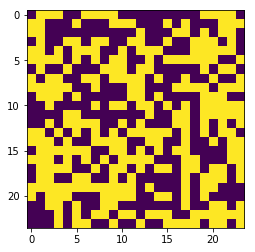

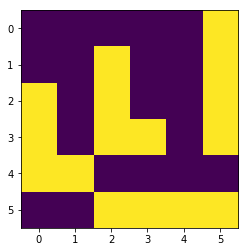

In [54]:
import matplotlib.pyplot as plt
plt.imshow(np.array(fake_mask[0,:24,:24]))
plt.show()
plt.imshow(np.array(mask[0].view(122,122))[:6,:6])
plt.show()

In [24]:
fake_feature.shape
lin1=nn.Linear(2, 128)
lin2=nn.Linear(512, 128)
print(lin1(nodes_2D.type(torch.float32)).shape)
print(lin2(fake_feature.type(torch.float32)).shape)
print(attn_mask.shape)


torch.Size([32, 14884, 128])
torch.Size([32, 256, 128])
torch.Size([32, 14884, 256])


In [34]:
class Attention():
    """
    Test fusing 2D goal encodings and map encodings with attention mechanism. 
    """

    def __init__(self):

        """
        args to include

        enc_size: int Dimension of encodings generated by encoder
        emb_size: int Size of embeddings used for queries, keys and values
        num_heads: int Number of attention heads

        """
        self.query_emb = nn.Linear(2, 128)
        self.key_emb = nn.Linear(512, 128)
        self.val_emb = nn.Linear(512, 128)
        self.mha = nn.MultiheadAttention(128, 1)

    def forward(self, query_goals, map_features, attn_mask) -> torch.Tensor:
        """
        Forward pass for attention aggregator
        """

        query = self.query_emb(query_goals).permute(1,0,2)
        keys = self.key_emb(map_features).permute(1,0,2)
        vals = self.val_emb(map_features).permute(1,0,2)
        op, _ = self.mha(query, keys, vals, attn_mask=attn_mask)
        # op = op.squeeze(0)
        # op = torch.cat((target_agent_enc, op), dim=-1)

        return op

In [38]:
test_attention= Attention()
test_attn_feat=test_attention.forward(query_goals=nodes_2D, map_features=fake_feature, attn_mask=attn_mask)
test_attn_feat.shape


torch.Size([14884, 32, 128])